### Import

In [64]:
import pandas as pd
import numpy as np
import random
import os


from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score, cross_validate, KFold
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit import RDConfig
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools as PandasTools
from rdkit import DataStructs
from rdkit.Chem.Subshape import SubshapeBuilder,SubshapeAligner,SubshapeObjects

In [65]:
CFG = {
    'NBITS':1024,
    'SEED':42,
}

In [66]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(CFG['SEED']) # Seed 고정

In [67]:
def pIC50_to_IC50(pic50_values):
    """Convert pIC50 values to IC50 (nM)."""
    return 10 ** (9 - pic50_values)

### DataLoad

In [68]:
# SMILES 데이터를 분자 지문으로 변환
def smiles_to_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=CFG['NBITS'])
        return np.array(fp)
    else:
        return np.zeros((CFG['NBITS'],))

In [69]:
# 학습 ChEMBL 데이터 로드
train = pd.read_csv('train.csv')  # 예시 파일 이름
test = pd.read_csv('test.csv') 
train.head()

,Molecule ChEMBL ID,Standard Type,Standard Relation,Standard Value,Standard Units,pChEMBL Value,Assay ChEMBL ID,Target ChEMBL ID,Target Name,Target Organism,Target Type,Document ChEMBL ID,IC50_nM,pIC50,Smiles
0,CHEMBL4443947,IC50,'=',0.022,nM,10.66,CHEMBL4361896,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,SINGLE PROTEIN,CHEMBL4359855,0.022,10.66,CN[C@@H](C)C(=O)N[C@H](C(=O)N1C[C@@H](NC(=O)CC...
1,CHEMBL4556091,IC50,'=',0.026,nM,10.59,CHEMBL4345131,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,SINGLE PROTEIN,CHEMBL4342485,0.026,10.59,CC(C)(O)[C@H](F)CN1Cc2cc(NC(=O)c3cnn4cccnc34)c...
2,CHEMBL4566431,IC50,'=',0.078,nM,10.11,CHEMBL4345131,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,SINGLE PROTEIN,CHEMBL4342485,0.078,10.11,CC(C)(O)[C@H](F)CN1Cc2cc(NC(=O)c3cnn4cccnc34)c...
3,CHEMBL4545898,IC50,'=',0.081,nM,10.09,CHEMBL4345131,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,SINGLE PROTEIN,CHEMBL4342485,0.081,10.09,CC(C)(O)[C@H](F)CN1Cc2cc(NC(=O)c3cnn4cccnc34)c...
4,CHEMBL4448950,IC50,'=',0.099,nM,10.00,CHEMBL4361896,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,SINGLE PROTEIN,CHEMBL4359855,0.099,10.00,COc1cc2c(OC[C@@H]3CCC(=O)N3)ncc(C#CCCCCCCCCCCC...


In [70]:
def preprocess_mol(df):
    molecules = df.Smiles.apply(Chem.MolFromSmiles)

    # 분자 리스트로부터 Morgan 지문 비트 벡터 생성
    mols_fps = [AllChem.GetMorganFingerprintAsBitVect(x, 2) for x in molecules]


    df.loc[:, 'MolLogP'] = molecules.apply(Descriptors.MolLogP)
    df.loc[:, 'HeavyAtomCount'] = molecules.apply(Descriptors.HeavyAtomCount)
    df.loc[:, 'HAccept'] = molecules.apply(Descriptors.NumHAcceptors)
    df.loc[:, 'Heteroatoms'] = molecules.apply(Descriptors.NumHeteroatoms)
    df.loc[:, 'HDonor'] = molecules.apply(Descriptors.NumHDonors)
    df.loc[:, 'MolWt'] = molecules.apply(Descriptors.MolWt)
    df.loc[:, 'RotableBonds'] = molecules.apply(Descriptors.NumRotatableBonds)
    df.loc[:, 'RingCount'] = molecules.apply(Descriptors.RingCount)
    # df.loc[:, 'Ipc'] = molecules.apply(Descriptors.Ipc)
    df.loc[:, 'HallKierAlpha'] = molecules.apply(Descriptors.HallKierAlpha)
    df.loc[:, 'NumValenceElectrons'] = molecules.apply(Descriptors.NumValenceElectrons)
    # df.loc[:, 'NumSaturatedRings'] = molecules.apply(Descriptors.NumSaturatedRings)
    # df.loc[:, 'NumAliphaticRings'] = molecules.apply(Descriptors.NumAliphaticRings)
    # df.loc[:, 'NumAromaticRings'] = molecules.apply(Descriptors.NumAromaticRings)
    # df.loc[:, 'NHOHCount'] = molecules.apply(Descriptors.NHOHCount)
    # df.loc[:, 'NOCount'] = molecules.apply(Descriptors.NOCount)
    df.loc[:, 'TPSA'] = molecules.apply(Descriptors.TPSA)

    return df




### Data Pre-processing

In [71]:
preprocess_mol(train)
preprocess_mol(test)

[21:12:54] DEPRECATION WARNING: please use MorganGenerator
[21:12:54] DEPRECATION WARNING: please use MorganGenerator
[21:12:54] DEPRECATION WARNING: please use MorganGenerator
[21:12:54] DEPRECATION WARNING: please use MorganGenerator
[21:12:54] DEPRECATION WARNING: please use MorganGenerator
[21:12:54] DEPRECATION WARNING: please use MorganGenerator
[21:12:54] DEPRECATION WARNING: please use MorganGenerator
[21:12:54] DEPRECATION WARNING: please use MorganGenerator
[21:12:54] DEPRECATION WARNING: please use MorganGenerator
[21:12:54] DEPRECATION WARNING: please use MorganGenerator
[21:12:54] DEPRECATION WARNING: please use MorganGenerator
[21:12:54] DEPRECATION WARNING: please use MorganGenerator
[21:12:54] DEPRECATION WARNING: please use MorganGenerator
[21:12:54] DEPRECATION WARNING: please use MorganGenerator
[21:12:54] DEPRECATION WARNING: please use MorganGenerator
[21:12:54] DEPRECATION WARNING: please use MorganGenerator
[21:12:54] DEPRECATION WARNING: please use MorganGenerat

,ID,Smiles,MolLogP,HeavyAtomCount,HAccept,Heteroatoms,HDonor,MolWt,RotableBonds,RingCount,HallKierAlpha,NumValenceElectrons,TPSA
0,TEST_000,O=C(C1=CSC(C2=CC=CN=C2)=N1)NC3=CC(NC4CCN(C)CC4...,5.28490,34,7,8,2,477.634,7,5,-2.97,178,79.38
1,TEST_001,N#CC1=CC(C=C2)=C(C=C1)N2C(N=C3)=NC(NC4CCCCC4)=...,4.82478,35,8,8,2,466.593,5,6,-3.70,178,96.38
2,TEST_002,N#CC(C=C1)=C(N[C@@H]2CCNC2)C=C1NC(N=C3)=NC=C3C...,2.26358,31,9,9,4,415.505,6,5,-3.48,158,115.51
3,TEST_003,N#CC(C=C1)=CC=C1NC(N=C2)=NC(NC3CC(NC(C=C)=O)CC...,3.94208,37,9,10,3,498.591,8,5,-4.23,190,129.78
4,TEST_004,N#CC(C=C1)=CC=C1NC(N=C2)=NC(NC3CC(N)CC3)=C2C(C...,3.59858,33,9,9,3,444.543,6,5,-3.48,170,126.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,TEST_108,N#CC1=CC(C=C2)=C(C=C1)N2C(N=C3)=NC(N4CCOCC4)=C...,2.91678,34,9,9,1,454.538,4,6,-3.74,172,96.82
109,TEST_109,O=C(C1=CSC(C2=CC=NC=C2)=N1)NC3=CC(NC4CCN(C(C)C...,4.84700,40,8,10,3,561.756,8,5,-3.50,212,102.49
110,TEST_110,N#Cc1ccc(Nc2ncc(cn2)c3cnn(c3)C4CCNCC4)cc1N[C@@...,2.65368,32,9,9,4,429.532,6,5,-3.48,164,115.51
111,TEST_111,O=C(C)N(CC1)CCC1N2N=CC(C3=CN=C(N4C(C=CC(C#N)=C...,3.33908,31,7,8,0,411.469,3,5,-3.99,154,92.63


In [72]:
#제거 변수
delete = ['Molecule ChEMBL ID','Standard Type','Standard Relation','Standard Value','Standard Units','pChEMBL Value','Assay ChEMBL ID','Target ChEMBL ID','Target Name','Target Organism',
          'Target Type','Document ChEMBL ID','pIC50','Smiles','IC50_nM']

In [73]:
y_train = train['pIC50'].values
x_train = train.drop(delete ,axis=1)

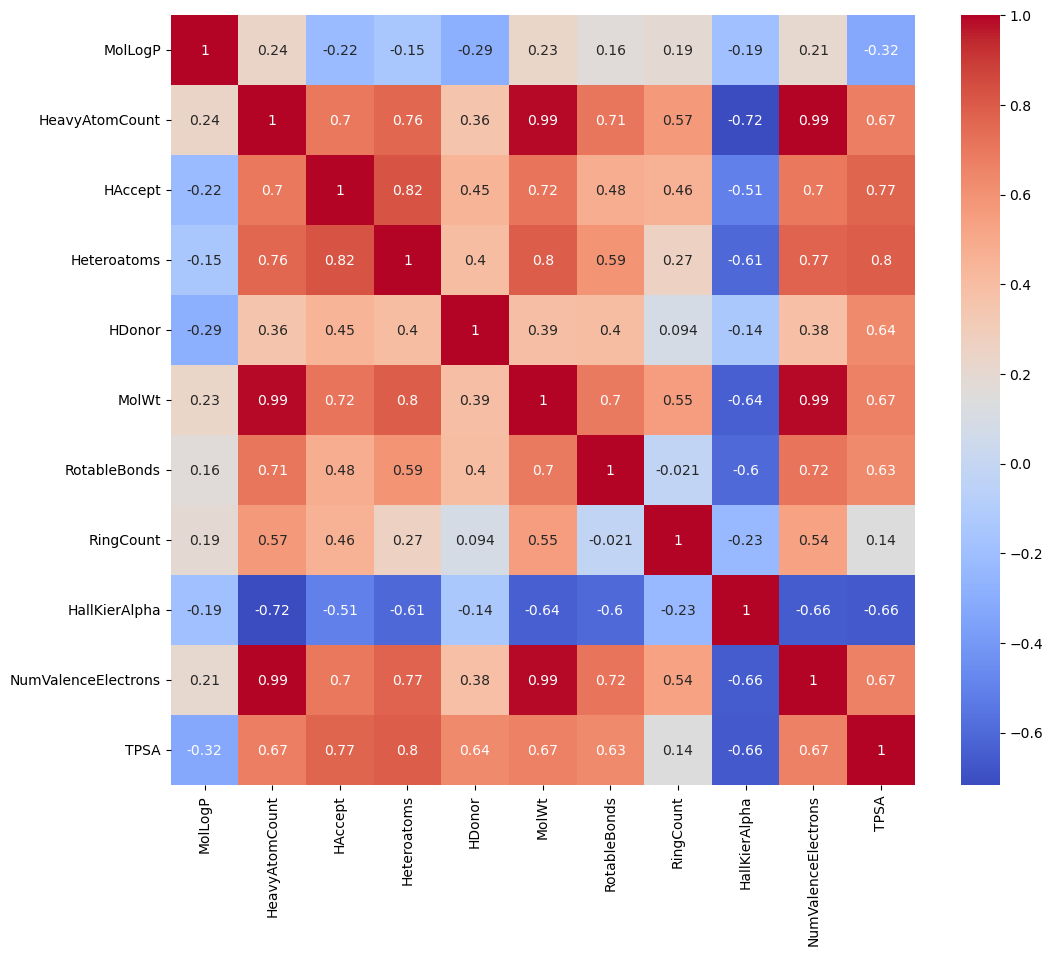

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = x_train.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()


### scaler 함수

In [75]:
def std_scaler(model, x_train, y_train):
    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train)
    nmse = cross_validate(model, x_train_scaled, y_train, scoring='neg_mean_squared_error', return_train_score=True, cv=5)
    mse = -1 * nmse['test_score']
    avg_mse = round(np.mean(mse), 4)
    rmse = np.sqrt(avg_mse)
    return print(f"평균 RMSE : {rmse :.4f}")

def MinMax_scaler(model, x_train, y_train):
    scaler = MinMaxScaler()
    x_train_scaled = scaler.fit_transform(x_train)
    nmse = cross_validate(model, x_train_scaled, y_train, scoring='neg_mean_squared_error', return_train_score=True, cv=5)
    mse = -1 * nmse['test_score']
    avg_mse = round(np.mean(mse), 4)
    rmse = np.sqrt(avg_mse)
    return print(f"평균 RMSE : {rmse :.4f}")

def robust_scaler(model, x_train, y_train):
    scaler = RobustScaler()
    x_train_scaled = scaler.fit_transform(x_train)
    nmse = cross_validate(model, x_train_scaled, y_train, scoring='neg_mean_squared_error', return_train_score=True, cv=5)
    mse = -1 * nmse['test_score']
    avg_mse = round(np.mean(mse), 4)
    rmse = np.sqrt(avg_mse)
    return print(f"평균 RMSE : {rmse :.4f}")

### 모델 임포트

In [76]:
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoost
from catboost import CatBoostRegressor

In [77]:
std_scaler(RandomForestRegressor(),x_train,y_train)

평균 RMSE : 1.1130


In [78]:
std_scaler(LinearRegression(),x_train,y_train)

평균 RMSE : 1.2134


In [79]:
std_scaler(DecisionTreeRegressor(),x_train,y_train)

평균 RMSE : 1.3071


In [80]:
std_scaler(ExtraTreeRegressor(),x_train,y_train)

평균 RMSE : 1.3242


In [81]:
std_scaler(XGBRegressor(),x_train,y_train)

평균 RMSE : 1.1117


In [82]:
std_scaler(LGBMRegressor(),x_train,y_train)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1170
[LightGBM] [Info] Number of data points in the train set: 1561, number of used features: 11
[LightGBM] [Info] Start training from score 7.195253
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1171
[LightGBM] [Info] Number of data points in the train set: 1561, number of used features: 11
[LightGBM] [Info] Start training from score 7.328431
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1176
[LightGBM] [Info] Number of data points in the train set: 1562, number of used features: 11
[LightGBM] [Info] Sta

In [83]:
std_scaler(CatBoostRegressor(verbose=0),x_train,y_train)

평균 RMSE : 1.0808


In [84]:
std_scaler(GradientBoostingRegressor(),x_train,y_train)

평균 RMSE : 1.1314


In [85]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.3, random_state=42)

In [86]:
from catboost import CatBoostRegressor

In [87]:
# # 모델 및 파라미터 그리드 설정

# model = CatBoostRegressor(learning_rate=0.1,  # 초기값, 후에 조정
#                           iterations=1000,  # 초기값, 후에 조정
#                           depth=6)  # 초기값, 후에 조정

# param_grid = {
#     'learning_rate': [ 0.01, 0.02,0.05,0.1,0.2],
#     'depth': [4, 6, 8, 10],
#     'l2_leaf_reg': [1, 3, 5,7, 9],
#     'iterations': [1000, 1500]
# }

# # GridSearchCV 설정
# grid_search = GridSearchCV(estimator=model,
#                            param_grid=param_grid,
#                            scoring='neg_mean_squared_error',
#                            cv=4,  # 교차 검증의 fold 수
#                            n_jobs=-1,  # 모든 코어 사용
#                            verbose=1)

# # 모델 학습
# grid_search.fit(x_train, y_train)

# # 최적의 파라미터 및 성능
# print("Best parameters found: ", grid_search.best_params_)
# print("Best MSE score: ", -grid_search.best_score_)

In [88]:
# # 모델 및 파라미터 그리드 설정

# model = RandomForestRegressor(n_estimators=100, random_state=42)

# param_grid = {
#     'n_estimators':[2800, 3000, 3300],
#     'max_depth' : [6, 8, 10, 12], 
#     'min_samples_leaf' : [8, 12, 18],
#     'min_samples_split' : [8, 16, 20]
# }

# # GridSearchCV 설정
# grid_search = GridSearchCV(model , param_grid=param_grid , cv=3, n_jobs=2, verbose=2 )


# # 모델 학습
# grid_search.fit(x_train, y_train)

# # 최적의 파라미터 및 성능
# print("Best parameters found: ", grid_search.best_params_)
# print("Best MSE score: ", -grid_search.best_score_)

In [89]:
std_scaler(CatBoostRegressor(learning_rate=0.05,depth=10,l2_leaf_reg=9,iterations=1000,verbose=0),x_train,y_train)

평균 RMSE : 0.7893


In [90]:
model = RandomForestRegressor(max_depth=12, min_samples_leaf=8, min_samples_split=8,n_estimators=2800)

scaler = StandardScaler()
x_train_scale = scaler.fit_transform(x_train)

model.fit(x_train_scale,y_train)


RandomForestRegressor(max_depth=12, min_samples_leaf=8, min_samples_split=8,
                      n_estimators=2800)

In [91]:
x_val_scale = scaler.fit_transform(x_val)
y_pred = model.predict(x_val_scale)
mse = mean_squared_error(y_val,y_pred)

rmse = np.sqrt(mse)
print(f"RMSE : {rmse :.4f}")

RMSE : 0.7853


In [92]:
# 변수 중요도 추출
importances = model.feature_importances_

# 중요도를 각 변수 이름과 함께 출력
for feature_name, importance in zip(x_train.columns, importances):
    print(f"{feature_name}: {importance:.4f}")

MolLogP: 0.0787
HeavyAtomCount: 0.0336
HAccept: 0.0339
Heteroatoms: 0.0356
HDonor: 0.0384
MolWt: 0.0482
RotableBonds: 0.0526
RingCount: 0.0642
HallKierAlpha: 0.1736
NumValenceElectrons: 0.2859
TPSA: 0.1554


In [ ]:
def get_new_col(df, new_col):
    cal_train = df.copy(deep=True)
    for i in new_col:
        split_col = i.split('*')
        if len(split_col) >= 2:
            col_name = ""
            for j in range(len(split_col)):
                if j == 0:
                    col_name = split_col[j]
                    cal_train['cal'] = cal_train[split_col[j]]
                else:
                    col_name += f'*{split_col[j]}'
                    cal_train['cal'] *= cal_train[split_col[j]]
            df[col_name] = cal_train['cal']
    return df

### Inference

In [93]:

test = test.drop(['ID','Smiles'],axis=1)
test = scaler.fit_transform(test)

y_pred = model.predict(test)

### Submission

In [94]:
submit = pd.read_csv('./sample_submission.csv')
submit['IC50_nM'] = pIC50_to_IC50(y_pred)
submit.head()

,ID,IC50_nM
0,TEST_000,66.446440
1,TEST_001,64.261674
2,TEST_002,90.572397
3,TEST_003,5.332897
4,TEST_004,13.560703


In [95]:
submit.to_csv('./baseline_submit.csv', index=False)